In [59]:
!pip install pulp
import numpy as np
from gurobipy import Model, GRB, quicksum
from tabulate import tabulate
import matplotlib.pyplot as plt
from IPython.display import Markdown, display


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


# Question 2

## Updated Costs

In [60]:
### User defined variables
promote = 0
month = 4
base_price = 40
promotion_price = base_price - 1
consumption = 0.10
forward_buy = 0.20

F = np.array([0, 1500, 3000, 3200, 3900, 2200, 2200, 1100])

### Variables based on input
n_months = len(F)-1
F = np.append(F, [0, 0])

In [61]:
def plot_inventory():
  t_values = list(range(1, n_months + 1))

  plt.plot(t_values, [I[t].x for t in t_values], marker='o', label='Inventory')
  plt.plot(t_values, [P[t].x for t in t_values], marker='s', label='Production')
  plt.plot(t_values, [D[t].x for t in t_values], marker='D', label='Demand')
  plt.plot(t_values, [S[t].x for t in t_values], marker='^', label='Stockout')
  plt.plot(t_values, [C[t].x for t in t_values], marker='x', label='Subcontracting')

  # Adding labels and legend
  plt.xlabel('Period')
  plt.ylabel('')
  plt.legend(loc='best')
  plt.title('Aggregate Plan')
  plt.grid(axis='y')

  # Show the plot
  plt.show()

|   Period |   Hired |   LaidOff |   Workforce |   OT Hours |   Inventory |   Stockout |   Subcontract |   Production |   Demand |   Price |
|---------:|--------:|----------:|------------:|-----------:|------------:|-----------:|--------------:|-------------:|---------:|--------:|
|        0 |       0 |         0 |          80 |          0 |        1000 |          0 |             0 |            0 |        0 |       - |
|        1 |       0 |        14 |          66 |          0 |        2140 |          0 |             0 |         2640 |     1500 |    40.0 |
|        2 |       0 |         0 |          66 |          0 |        1780 |          0 |             0 |         2640 |     3000 |    40.0 |
|        3 |       0 |         0 |          66 |          0 |        1220 |          0 |             0 |         2640 |     3200 |    40.0 |
|        4 |       0 |         0 |          66 |          0 |           0 |          0 |            40 |         2640 |     3900 |    40.0 |
|        5 |       0 |        12 |          54 |          0 |           0 |         40 |             0 |         2160 |     2200 |    40.0 |
|        6 |       0 |         6 |          48 |          0 |           0 |        320 |             0 |         1920 |     2200 |    40.0 |
|        7 |       0 |         0 |          48 |          0 |         500 |          0 |             0 |         1920 |     1100 |    40.0 |

Minimum Cost : $ 460,840.00
Total Revenue: $ 684,000.00
Profit       : $ 223,160.00
updated_january_costs : 79920.0


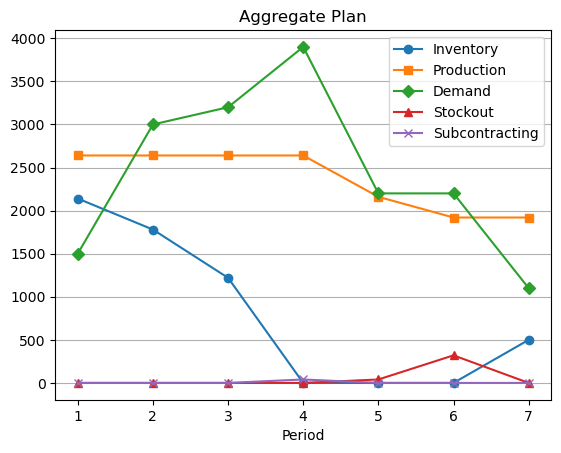

In [62]:

# Create a Gurobi model
model = Model("MinimizeCost2")

H = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(0, n_months+1)}
L = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(0, n_months+1)}
W = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(0, n_months+1)}
O = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(0, n_months+1)}
I = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(0, n_months+1)}
S = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(0, n_months+1)}
C = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(0, n_months+1)}
P = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(0, n_months+1)}
D = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(0, n_months+1)}

# Update the model
model.update()

# Set objective function - Total cost = Production & Transportation cost across network + Fixed cost of low cap line + fixed cost of high cap line
model.setObjective(
    quicksum( 300*H[t] + 500*L[t] + 640*W[t] + 6*O[t] + 2*I[t] + 5*S[t] + 30*C[t] + 10*P[t] for t in range(1, n_months+1) ),
    GRB.MINIMIZE)

### Constraints
for t in range(1, n_months+1):

  # Workforce size for each month is based on hiring and layoffs, W_t = W_{t-1} + H_t - L_t
  model.addConstr(W[0] == 80, name=f"Workforce_Beg")
  model.addConstr(W[t] - W[t-1] - H[t] + L[t] == 0, name=f"Workforce_size_constraint_{t}")

  # Demand constraints
  if promote == 0:
      model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
  else:
      if t == month:
          model.addConstr(D[t] == F[t] * (1 + consumption) + forward_buy * (F[t+1] + F[t+2]), name=f"D_constraint_{t}")
      else:
          if t <= 2 + promote:
              if t > promote:
                  model.addConstr(D[t] == (1 - forward_buy) * F[t], name=f"D_constraint_{t}")
              else:
                  model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
          else:
              model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")

  # Inventory balance constraint: I_{t-1} + P_t + C_t = D_t + S_{t-1} + I_t - S_t
  model.addConstr(I[0] == 1000, name=f"Inventory_Beg")
  model.addConstr(I[t-1] + P[t] + C[t] - D[t] - S[t-1] - I[t] + S[t] == 0, name=f"Inventory_constraint_{t}")
  model.addConstr(I[n_months] >= 500, name=f"Inventory_End")

  # Stockout constraint: No stockout at the end
  model.addConstr(S[n_months] == 0, name=f"Stockout_End")

  # Production <= Capacity P_t <= 40 W_t + O_t/4
  model.addConstr(40*W[t] + O[t]/4 - P[t] >= 0, name=f"Capacity_constraint_{t}")

  # Overtime constraint O_t <= 10 W_t
  model.addConstr(10*W[t] - O[t] >= 0, name=f"Overtime_constraint_{t}")


# Suppress optimization output
model.Params.OutputFlag = 0

# Optimize the model
model.optimize()

### Calculate price
Pr = np.zeros(n_months+1)
for t in range(0, n_months + 1):
  if promote == 1 and t == month:
    Pr[t] = promotion_price
  else:
    Pr[t] = base_price
  if t == 0:
    Pr[t] = np.nan

### Total revenue = sumproduct (demand*price)
revenue = sum([D[t].x * Pr[t] for t in range(1, n_months + 1)])

opt_results = []
for t in range(0, n_months + 1):
    row = [
        t,
        int(H[t].x),
        int(L[t].x),
        int(W[t].x),
        int(O[t].x),
        int(I[t].x),
        int(S[t].x),
        int(C[t].x),
        int(P[t].x),
        int(D[t].x),
        "{:.1f}".format(Pr[t]) if t > 0 else "-"
    ]
    opt_results.append(row)

# Slightly longer abbreviations for headers
headers = ["Period", "Hired", "LaidOff", "Workforce", "OT Hours", "Inventory", "Stockout", "Subcontract", "Production", "Demand", "Price"]

# Use a compact table format
table = tabulate(opt_results, headers=headers, tablefmt="pipe", numalign="right", stralign="right")

# Display the table in Jupyter notebook
display(Markdown(table))

mimimum_cost_updated = model.objVal

print(f"Minimum Cost : $ {model.objVal:,.2f}")
print(f"Total Revenue: $ {revenue:,.2f}")
print(f"Profit       : $ {(revenue-model.objVal):,.2f}")
# After optimizing the model with updated demand
updated_january_costs = 300 * H[1].x + 500 * L[1].x + 640 * W[1].x + 6 * O[1].x + 2 * I[1].x + 5 * S[1].x + 30 * C[1].x + 10 * P[1].x
print("updated_january_costs :", updated_january_costs)
plot_inventory()

## Original Costs

|   Period |   Hired |   LaidOff |   Workforce |   OT Hours |   Inventory |   Stockout |   Subcontract |   Production |   Demand |   Price |
|---------:|--------:|----------:|------------:|-----------:|------------:|-----------:|--------------:|-------------:|---------:|--------:|
|        0 |       0 |         0 |          80 |          0 |        1000 |          0 |             0 |            0 |        0 |       - |
|        1 |       0 |        15 |          65 |          0 |        2000 |          0 |             0 |         2600 |     1600 |    40.0 |
|        2 |       0 |         0 |          65 |          0 |        1600 |          0 |             0 |         2600 |     3000 |    40.0 |
|        3 |       0 |         0 |          65 |          0 |        1000 |          0 |             0 |         2600 |     3200 |    40.0 |
|        4 |       0 |         1 |          64 |          0 |           0 |        220 |            20 |         2560 |     3800 |    40.0 |
|        5 |       0 |         0 |          64 |          0 |         140 |          0 |             0 |         2560 |     2200 |    40.0 |
|        6 |       0 |         0 |          64 |          0 |         500 |          0 |             0 |         2560 |     2200 |    40.0 |

Minimum Cost : $ 422,660.00
Total Revenue: $ 640,000.00
Profit       : $ 217,340.00
original_january_costs : 79100.0


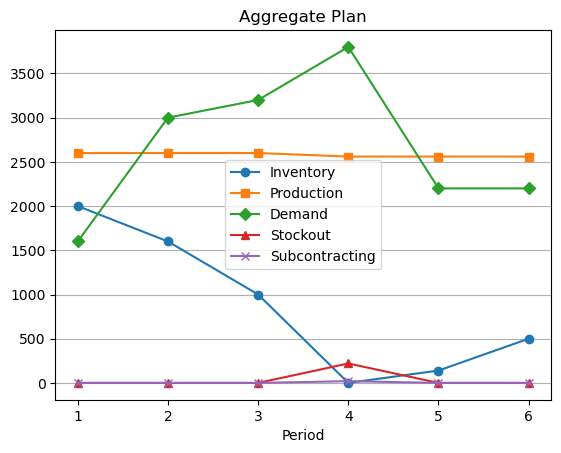

In [63]:

### User defined variables
F = np.array([0, 1600, 3000, 3200, 3800, 2200, 2200])

### Variables based on input
n_months = len(F)-1
F = np.append(F, [0, 0])


# Create a Gurobi model
model = Model("MinimizeCost")

H = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(0, n_months+1)}
L = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(0, n_months+1)}
W = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(0, n_months+1)}
O = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(0, n_months+1)}
I = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(0, n_months+1)}
S = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(0, n_months+1)}
C = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(0, n_months+1)}
P = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(0, n_months+1)}
D = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(0, n_months+1)}

# Update the model
model.update()

# Set objective function - Total cost = Production & Transportation cost across network + Fixed cost of low cap line + fixed cost of high cap line
model.setObjective(
    quicksum( 300*H[t] + 500*L[t] + 640*W[t] + 6*O[t] + 2*I[t] + 5*S[t] + 30*C[t] + 10*P[t] for t in range(1, n_months+1) ),
    GRB.MINIMIZE)

### Constraints
for t in range(1, n_months+1):

  # Workforce size for each month is based on hiring and layoffs, W_t = W_{t-1} + H_t - L_t
  model.addConstr(W[0] == 80, name=f"Workforce_Beg")
  model.addConstr(W[t] - W[t-1] - H[t] + L[t] == 0, name=f"Workforce_size_constraint_{t}")

  # Demand constraints
  if promote == 0:
      model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
  else:
      if t == month:
          model.addConstr(D[t] == F[t] * (1 + consumption) + forward_buy * (F[t+1] + F[t+2]), name=f"D_constraint_{t}")
      else:
          if t <= 2 + promote:
              if t > promote:
                  model.addConstr(D[t] == (1 - forward_buy) * F[t], name=f"D_constraint_{t}")
              else:
                  model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
          else:
              model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")

  # Inventory balance constraint: I_{t-1} + P_t + C_t = D_t + S_{t-1} + I_t - S_t
  model.addConstr(I[0] == 1000, name=f"Inventory_Beg")
  model.addConstr(I[t-1] + P[t] + C[t] - D[t] - S[t-1] - I[t] + S[t] == 0, name=f"Inventory_constraint_{t}")
  model.addConstr(I[n_months] >= 500, name=f"Inventory_End")

  # Stockout constraint: No stockout at the end
  model.addConstr(S[n_months] == 0, name=f"Stockout_End")

  # Production <= Capacity P_t <= 40 W_t + O_t/4
  model.addConstr(40*W[t] + O[t]/4 - P[t] >= 0, name=f"Capacity_constraint_{t}")

  # Overtime constraint O_t <= 10 W_t
  model.addConstr(10*W[t] - O[t] >= 0, name=f"Overtime_constraint_{t}")


# Suppress optimization output
model.Params.OutputFlag = 0

# Optimize the model
model.optimize()

### Calculate price
Pr = np.zeros(n_months+1)
for t in range(0, n_months + 1):
  if promote == 1 and t == month:
    Pr[t] = promotion_price
  else:
    Pr[t] = base_price
  if t == 0:
    Pr[t] = np.nan

### Total revenue = sumproduct (demand*price)
revenue = sum([D[t].x * Pr[t] for t in range(1, n_months + 1)])

opt_results = []
for t in range(0, n_months + 1):
    row = [
        t,
        int(H[t].x),
        int(L[t].x),
        int(W[t].x),
        int(O[t].x),
        int(I[t].x),
        int(S[t].x),
        int(C[t].x),
        int(P[t].x),
        int(D[t].x),
        "{:.1f}".format(Pr[t]) if t > 0 else "-"
    ]
    opt_results.append(row)

# Slightly longer abbreviations for headers
headers = ["Period", "Hired", "LaidOff", "Workforce", "OT Hours", "Inventory", "Stockout", "Subcontract", "Production", "Demand", "Price"]

# Use a compact table format
table = tabulate(opt_results, headers=headers, tablefmt="pipe", numalign="right", stralign="right")

# Display the table in Jupyter notebook
display(Markdown(table))

print(f"Minimum Cost : $ {model.objVal:,.2f}")
print(f"Total Revenue: $ {revenue:,.2f}")
print(f"Profit       : $ {(revenue-model.objVal):,.2f}")

original_january_costs = 300 * H[1].x + 500 * L[1].x + 640 * W[1].x + 6 * O[1].x + 2 * I[1].x + 5 * S[1].x + 30 * C[1].x + 10 * P[1].x
print("original_january_costs :", original_january_costs)
plot_inventory()

# Question 3

In [64]:
# Calculate the impact
impact_on_january_costs = updated_january_costs - original_january_costs

print(f"Impact on January Costs: $ {impact_on_january_costs:,.2f}")

Impact on January Costs: $ 820.00


# Question 4

## Method 1

Cost difference for Feb through June: $ -79,100.00


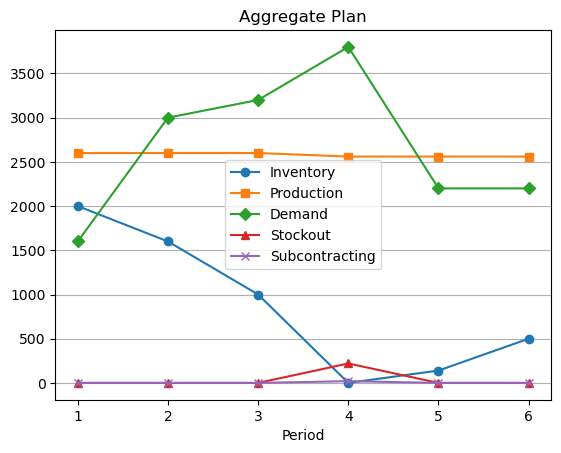

In [65]:
# actual inventory at the end of January
actual_inventory_Jan = 1000

# Update the initial inventory constraint
model.getConstrByName("Inventory_Beg").setAttr(GRB.Attr.RHS, actual_inventory_Jan)

# Re-optimize the model
model.optimize()

# calculate the total cost for February through June in the updated plan
total_cost_updated_plan = sum(300*H[t].x + 500*L[t].x + 640*W[t].x + 6*O[t].x + 2*I[t].x + 5*S[t].x + 30*C[t].x + 10*P[t].x for t in range(2, 7))

# calculated the total cost for the original plan in a similar way
total_cost_original_plan = 422660

# Calculate the cost difference
cost_difference = total_cost_updated_plan - total_cost_original_plan

print(f"Cost difference for Feb through June: $ {cost_difference:,.2f}")

# Plot the inventory and other relevant information
plot_inventory()

## Method 2

In [66]:
import pulp
from pulp import LpProblem, LpVariable, lpSum, LpMinimize
import numpy as np

# Updated demand forecast
demand_forecast = {
    'January': 1500,
    'February': 3000,
    'March': 3200,
    'April': 3900,
    'May': 2200,
    'June': 2200,
    'July': 1100
}

# Costs
materials_cost_per_unit = 10
inventory_holding_cost_per_unit_per_month = 2
marginal_cost_of_stockout_per_unit_per_month = 5

# Assuming a simple production model where production meets demand exactly
# and ignoring other constraints for simplicity

# Initialize the problem
prob = LpProblem("Updated_SOP", LpMinimize)

# Decision variables
months = list(demand_forecast.keys())
production_vars = LpVariable.dicts("Production", months, lowBound=0, cat='Continuous')
inventory_vars = LpVariable.dicts("Inventory", months, lowBound=0, cat='Continuous')
stockout_vars = LpVariable.dicts("Stockout", months, lowBound=0, cat='Continuous')

# Objective function
prob += lpSum([
    materials_cost_per_unit * production_vars[m] + 
    inventory_holding_cost_per_unit_per_month * inventory_vars[m] +
    marginal_cost_of_stockout_per_unit_per_month * stockout_vars[m] 
    for m in months
])

# Constraints
# Assuming initial inventory is carried over from the previous calculation
initial_inventory = 1000 + (1600 - 1500)  # Adjusted for actual January demand
prob += inventory_vars['January'] == initial_inventory

for i, m in enumerate(months):
    if i > 0:  # Starting from February since January is already set
        prob += production_vars[m] == demand_forecast[m], f"Production_meets_demand_{m}"
        prob += inventory_vars[m] == (inventory_vars[months[i-1]] + production_vars[m] - demand_forecast[m]), f"Inventory_balance_{m}"

# Solve the problem
prob.solve()

# Calculate the updated total cost
updated_total_cost = pulp.value(prob.objective)

# Original demand forecast for calculation
original_demand = np.array([1600, 3000, 3200, 3800, 2200, 2200])

# Calculate the original total cost
original_material_cost = sum(original_demand) * materials_cost_per_unit
# Simplified, assuming no inventory carrying over for simplicity in original plan
original_total_cost = original_material_cost

# Calculate the cost difference
cost_difference = updated_total_cost - original_total_cost
print(f"Updated Total Cost: ${updated_total_cost:.2f}")
print(f"Original Total Cost: ${original_total_cost:.2f}")
print(f"Cost difference for Feb through June: ${cost_difference:.2f}")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sunny/anaconda3/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/8m/vyr01cvs6bbgh1rk6mdmlftm0000gn/T/ddb53ddddf7a43e5996a428a1f9c9978-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/8m/vyr01cvs6bbgh1rk6mdmlftm0000gn/T/ddb53ddddf7a43e5996a428a1f9c9978-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 18 COLUMNS
At line 65 RHS
At line 79 BOUNDS
At line 80 ENDATA
Problem MODEL has 13 rows, 21 columns and 25 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-13) rows, 0 (-21) columns and 0 (-25) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 171400
After Postsolve, objective 171400, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 171400 - 0 iterations time 0.002, Presolve 0.00
Option for printingOptions cha